In [1]:
from pathlib import Path
import pandas as pd
from keras.layers import BatchNormalization, Dense, Input, Conv1D, Add, ELU, Flatten, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, Softmax, Concatenate, Reshape, Multiply, ReLU
from keras.optimizers import SGD
from keras import activations
from keras import Model
from keras.initializers import HeNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model

In [2]:
def load_concatenated_aud_vid(
    file_path: Path, feature_type: str, delimeter: str
): #-> Dict[str, Dict[str, pd.DataFrame]]:
    """TODO"""
    if not Path.exists(file_path):
        print("Directory does not exist. Check input feature directory")
    # loaded_features: Dict = {}
    loaded_features = {}
    generator = (file_path).glob("*")
    for path in generator:
        str_path = str(path)
        start = str_path.rindex("\\")
        end = str_path.rindex("_")
        participant_id = str_path[start + 1 : end]
        full_path = path / ("features/" + participant_id + feature_type)
        participant_id_df = pd.read_csv(full_path, sep=delimeter)
        participant_id_df.columns = participant_id_df.columns.str.replace(" ", "")
        loaded_features[participant_id] = participant_id_df
    if not loaded_features:
        print(
            "No samples loaded, check the samples are available in the input directory."
        )
    return loaded_features

In [3]:
# directly load saved (combined) audio video csv files
daic_audio_video_train = load_concatenated_aud_vid(Path("daic_processed_1/concat_vid_aud/train/"), "_Concat_openface_mfcc.csv", ",")
daic_audio_video_dev = load_concatenated_aud_vid(Path("daic_processed_1/concat_vid_aud/dev/"), "_Concat_openface_mfcc.csv", ",")
daic_audio_video_test = load_concatenated_aud_vid(Path("daic_processed_1/concat_vid_aud/test/"), "_Concat_openface_mfcc.csv", ",")

In [4]:
for subject_id, subject_df in daic_audio_video_train.items():
    subject_df.drop(columns=["frame", "timestamp", "confidence", "success", "AU01_c", "AU02_c", "AU04_c", "AU05_c", "AU06_c", "AU07_c", "AU09_c", "AU10_c", "AU12_c", "AU14_c", "AU15_c", "AU17_c", "AU20_c", "AU23_c", "AU25_c", "AU26_c", "AU28_c", "AU45_c"], inplace=True)
for subject_id, subject_df in daic_audio_video_dev.items():
    subject_df.drop(columns=["frame", "timestamp", "confidence", "success", "AU01_c", "AU02_c", "AU04_c", "AU05_c", "AU06_c", "AU07_c", "AU09_c", "AU10_c", "AU12_c", "AU14_c", "AU15_c", "AU17_c", "AU20_c", "AU23_c", "AU25_c", "AU26_c", "AU28_c", "AU45_c"], inplace=True)
for subject_id, subject_df in daic_audio_video_test.items():
    subject_df.drop(columns=["frame", "timestamp", "confidence", "success", "AU01_c", "AU02_c", "AU04_c", "AU05_c", "AU06_c", "AU07_c", "AU09_c", "AU10_c", "AU12_c", "AU14_c", "AU15_c", "AU17_c", "AU20_c", "AU23_c", "AU25_c", "AU26_c", "AU28_c", "AU45_c"], inplace=True)

In [6]:
all_data = [daic_audio_video_train, daic_audio_video_dev, daic_audio_video_test]
def find_min_max():
    """Finds the minimum and maximum values of all feature for normalisation."""
    # only for openface features at the moment

    # !!As of now this doesn't work correctly!!
    # LEAVE THIS TO DO AFTER PREPROCESSING, some of feature values for success == 0 are ridiculous and will most likely need to be zeroed
    min_max = {
        "min": {
            "pose_Tx": 1000,
            "pose_Ty": 1000,
            "pose_Tz": 1000,
            "pose_Rx": 1000,
            "pose_Ry": 1000,
            "pose_Rz": 1000,
            "gaze_0_x": 1000,
            "gaze_0_y": 1000,
            "gaze_0_z": 1000,
            "gaze_1_x": 1000,
            "gaze_1_y": 1000,
            "gaze_1_z": 1000,
            "gaze_angle_x": 1000,
            "gaze_angle_y": 1000,
            "AU01_r": 1000,
            "AU02_r": 1000,
            "AU04_r": 1000,
            "AU05_r": 1000,
            "AU06_r": 1000,
            "AU07_r": 1000,
            "AU09_r": 1000,
            "AU10_r": 1000,
            "AU12_r": 1000,
            "AU14_r": 1000,
            "AU15_r": 1000,
            "AU17_r": 1000,
            "AU20_r": 1000,
            "AU23_r": 1000,
            "AU25_r": 1000,
            "AU26_r": 1000,
            "AU45_r": 1000,
            "pcm_fftMag_mfcc[0]": 1000,
            "pcm_fftMag_mfcc[1]": 1000,
            "pcm_fftMag_mfcc[2]": 1000,
            "pcm_fftMag_mfcc[3]": 1000,
            "pcm_fftMag_mfcc[4]": 1000,
            "pcm_fftMag_mfcc[5]": 1000,
            "pcm_fftMag_mfcc[6]": 1000,
            "pcm_fftMag_mfcc[7]": 1000,
            "pcm_fftMag_mfcc[8]": 1000,
            "pcm_fftMag_mfcc[9]": 1000,
            "pcm_fftMag_mfcc[10]": 1000,
            "pcm_fftMag_mfcc[11]": 1000,
            "pcm_fftMag_mfcc[12]": 1000,
            "pcm_fftMag_mfcc_de[0]": 1000,
            "pcm_fftMag_mfcc_de[1]": 1000,
            "pcm_fftMag_mfcc_de[2]": 1000,
            "pcm_fftMag_mfcc_de[3]": 1000,
            "pcm_fftMag_mfcc_de[4]": 1000,
            "pcm_fftMag_mfcc_de[5]": 1000,
            "pcm_fftMag_mfcc_de[6]": 1000,
            "pcm_fftMag_mfcc_de[7]": 1000,
            "pcm_fftMag_mfcc_de[8]": 1000,
            "pcm_fftMag_mfcc_de[9]": 1000,
            "pcm_fftMag_mfcc_de[10]": 1000,
            "pcm_fftMag_mfcc_de[11]": 1000,
            "pcm_fftMag_mfcc_de[12]": 1000,
            "pcm_fftMag_mfcc_de_de[0]": 1000,
            "pcm_fftMag_mfcc_de_de[1]": 1000,
            "pcm_fftMag_mfcc_de_de[2]": 1000,
            "pcm_fftMag_mfcc_de_de[3]": 1000,
            "pcm_fftMag_mfcc_de_de[4]": 1000,
            "pcm_fftMag_mfcc_de_de[5]": 1000,
            "pcm_fftMag_mfcc_de_de[6]": 1000,
            "pcm_fftMag_mfcc_de_de[7]": 1000,
            "pcm_fftMag_mfcc_de_de[8]": 1000,
            "pcm_fftMag_mfcc_de_de[9]": 1000,
            "pcm_fftMag_mfcc_de_de[10]": 1000,
            "pcm_fftMag_mfcc_de_de[11]": 1000,
            "pcm_fftMag_mfcc_de_de[12]": 1000,
        },
        "max": {
            "pose_Tx": 0,
            "pose_Ty": 0,
            "pose_Tz": 0,
            "pose_Rx": 0,
            "pose_Ry": 0,
            "pose_Rz": 0,
            "gaze_0_x": 0,
            "gaze_0_y": 0,
            "gaze_0_z": 0,
            "gaze_1_x": 0,
            "gaze_1_y": 0,
            "gaze_1_z": 0,
            "gaze_angle_x": 0,
            "gaze_angle_y": 0,
            "AU01_r": 0,
            "AU02_r": 0,
            "AU04_r": 0,
            "AU05_r": 0,
            "AU06_r": 0,
            "AU07_r": 0,
            "AU09_r": 0,
            "AU10_r": 0,
            "AU12_r": 0,
            "AU14_r": 0,
            "AU15_r": 0,
            "AU17_r": 0,
            "AU20_r": 0,
            "AU23_r": 0,
            "AU25_r": 0,
            "AU26_r": 0,
            "AU45_r": 0,
            "pcm_fftMag_mfcc[0]": -1000,
            "pcm_fftMag_mfcc[1]": -1000,
            "pcm_fftMag_mfcc[2]": -1000,
            "pcm_fftMag_mfcc[3]": -1000,
            "pcm_fftMag_mfcc[4]": -1000,
            "pcm_fftMag_mfcc[5]": -1000,
            "pcm_fftMag_mfcc[6]": -1000,
            "pcm_fftMag_mfcc[7]": -1000,
            "pcm_fftMag_mfcc[8]": -1000,
            "pcm_fftMag_mfcc[9]": -1000,
            "pcm_fftMag_mfcc[10]": -1000,
            "pcm_fftMag_mfcc[11]": -1000,
            "pcm_fftMag_mfcc[12]": -1000,
            "pcm_fftMag_mfcc_de[0]": -1000,
            "pcm_fftMag_mfcc_de[1]": -1000,
            "pcm_fftMag_mfcc_de[2]": -1000,
            "pcm_fftMag_mfcc_de[3]": -1000,
            "pcm_fftMag_mfcc_de[4]": -1000,
            "pcm_fftMag_mfcc_de[5]": -1000,
            "pcm_fftMag_mfcc_de[6]": -1000,
            "pcm_fftMag_mfcc_de[7]": -1000,
            "pcm_fftMag_mfcc_de[8]": -1000,
            "pcm_fftMag_mfcc_de[9]": -1000,
            "pcm_fftMag_mfcc_de[10]": -1000,
            "pcm_fftMag_mfcc_de[11]": -1000,
            "pcm_fftMag_mfcc_de[12]": -1000,
            "pcm_fftMag_mfcc_de_de[0]": -1000,
            "pcm_fftMag_mfcc_de_de[1]": -1000,
            "pcm_fftMag_mfcc_de_de[2]": -1000,
            "pcm_fftMag_mfcc_de_de[3]": -1000,
            "pcm_fftMag_mfcc_de_de[4]": -1000,
            "pcm_fftMag_mfcc_de_de[5]": -1000,
            "pcm_fftMag_mfcc_de_de[6]": -1000,
            "pcm_fftMag_mfcc_de_de[7]": -1000,
            "pcm_fftMag_mfcc_de_de[8]": -1000,
            "pcm_fftMag_mfcc_de_de[9]": -1000,
            "pcm_fftMag_mfcc_de_de[10]": -1000,
            "pcm_fftMag_mfcc_de_de[11]": -1000,
            "pcm_fftMag_mfcc_de_de[12]": -1000,
        },
    }
    for subset in all_data:
        for subject_id, subject_df in subset.items():
            # for subject, dataframe in subjects.items():
            for feature, _ in min_max["min"].items():
                min_value = subject_df.iloc[:][feature].min()
                max_value = subject_df.iloc[:][feature].max()
                # if min_value < -1000:
                #     print(subject_id)
                # if max_value > 1000:
                #     print(subject_id)
                if min_value < min_max["min"][feature]:
                    min_max["min"][feature] = min_value
                if max_value > min_max["max"][feature]:
                    min_max["max"][feature] = max_value
    return min_max
min_max_values = find_min_max()
# print(min_max_values)
min_max_df = pd.DataFrame.from_dict(min_max_values, orient="index")

In [ ]:
normalised_dev = daic_audio_video_dev.copy()
normalised_test = daic_audio_video_test.copy()
normalised_train = daic_audio_video_train.copy()
all_data = [normalised_dev, normalised_test, normalised_train]
for subset in all_data:
    for subject_id, subject_df in subset.items():
        print(subject_id)
        for row in range(subject_df.shape[0]):
            values = subject_df.iloc[row]
            normalised_values = (values-min_max_df.loc["min"])/(min_max_df.loc["max"]-min_max_df.loc["min"])
            subject_df.iloc[row] = normalised_values

In [ ]:
# directly load saved (combined) audio video csv files
normalised_train = load_concatenated_aud_vid(Path("daic_processed_1/normalised_concat_vid_aud/train/"), "_normalised_openface_mfcc.csv", ",")
normalised_dev = load_concatenated_aud_vid(Path("daic_processed_1/normalised_concat_vid_aud/dev/"), "_normalised_openface_mfcc.csv", ",")
normalised_test = load_concatenated_aud_vid(Path("daic_processed_1/normalised_concat_vid_aud/test/"), "_normalised_openface_mfcc.csv", ",")

In [5]:
resampled_dev_pose = {}
resampled_train_pose = {}
resampled_test_pose = {}
resampled_dev_AU = {}
resampled_train_AU = {}
resampled_test_AU = {}
resampled_dev_gaze = {}
resampled_train_gaze = {}
resampled_test_gaze = {}
for subject_id, subject_df in daic_audio_video_dev.items():
    temp1 = subject_df.copy().loc[0:4999][["pose_Tx", "pose_Ty", "pose_Tz", "pose_Rx", "pose_Ry", "pose_Rz"]]
    temp2 = subject_df.copy().loc[0:4999][[ "AU01_r", "AU02_r", "AU04_r", "AU05_r", "AU06_r", "AU07_r", "AU09_r", "AU10_r", "AU12_r", "AU14_r", "AU15_r", "AU17_r", "AU20_r", "AU23_r", "AU25_r", "AU26_r", "AU45_r"]]
    temp3 = subject_df.copy().loc[0:4999][["gaze_0_x", "gaze_0_y", "gaze_0_z", "gaze_1_x", "gaze_1_y", "gaze_1_z", "gaze_angle_x", "gaze_angle_y"]]
    resampled_dev_pose[subject_id] = temp1
    resampled_dev_AU[subject_id] = temp2
    resampled_dev_gaze[subject_id] = temp3
for subject_id, subject_df in daic_audio_video_train.items():
    temp = subject_df.copy().loc[0:4999][["pose_Tx", "pose_Ty", "pose_Tz", "pose_Rx", "pose_Ry", "pose_Rz"]]
    temp2 = subject_df.copy().loc[0:4999][[ "AU01_r", "AU02_r", "AU04_r", "AU05_r", "AU06_r", "AU07_r", "AU09_r", "AU10_r", "AU12_r", "AU14_r", "AU15_r", "AU17_r", "AU20_r", "AU23_r", "AU25_r", "AU26_r", "AU45_r"]]
    temp3 = subject_df.copy().loc[0:4999][["gaze_0_x", "gaze_0_y", "gaze_0_z", "gaze_1_x", "gaze_1_y", "gaze_1_z", "gaze_angle_x", "gaze_angle_y"]]
    resampled_train_pose[subject_id] = temp1
    resampled_train_AU[subject_id] = temp2
    resampled_train_gaze[subject_id] = temp3
for subject_id, subject_df in daic_audio_video_test.items():
    temp = subject_df.copy().loc[0:4999][["pose_Tx", "pose_Ty", "pose_Tz", "pose_Rx", "pose_Ry", "pose_Rz"]]
    temp2 = subject_df.copy().loc[0:4999][[ "AU01_r", "AU02_r", "AU04_r", "AU05_r", "AU06_r", "AU07_r", "AU09_r", "AU10_r", "AU12_r", "AU14_r", "AU15_r", "AU17_r", "AU20_r", "AU23_r", "AU25_r", "AU26_r", "AU45_r"]]
    temp3 = subject_df.copy().loc[0:4999][["gaze_0_x", "gaze_0_y", "gaze_0_z", "gaze_1_x", "gaze_1_y", "gaze_1_z", "gaze_angle_x", "gaze_angle_y"]]
    resampled_test_pose[subject_id] = temp1
    resampled_test_AU[subject_id] = temp2
    resampled_test_gaze[subject_id] = temp3

        

In [16]:
resampled_dev_pose = {}
resampled_train_pose = {}
resampled_test_pose = {}
resampled_dev_AU = {}
resampled_train_AU = {}
resampled_test_AU = {}
resampled_dev_gaze = {}
resampled_train_gaze = {}
resampled_test_gaze = {}
for subject_id, subject_df in normalised_dev.items():
    temp1 = subject_df.copy().loc[0:4999][["pose_Tx", "pose_Ty", "pose_Tz", "pose_Rx", "pose_Ry", "pose_Rz"]]
    temp2 = subject_df.copy().loc[0:4999][[ "AU01_r", "AU02_r", "AU04_r", "AU05_r", "AU06_r", "AU07_r", "AU09_r", "AU10_r", "AU12_r", "AU14_r", "AU15_r", "AU17_r", "AU20_r", "AU23_r", "AU25_r", "AU26_r", "AU45_r"]]
    temp3 = subject_df.copy().loc[0:4999][["gaze_0_x", "gaze_0_y", "gaze_0_z", "gaze_1_x", "gaze_1_y", "gaze_1_z", "gaze_angle_x", "gaze_angle_y"]]
    resampled_dev_pose[subject_id] = temp1
    resampled_dev_AU[subject_id] = temp2
    resampled_dev_gaze[subject_id] = temp3
for subject_id, subject_df in normalised_train.items():
    temp = subject_df.copy().loc[0:4999][["pose_Tx", "pose_Ty", "pose_Tz", "pose_Rx", "pose_Ry", "pose_Rz"]]
    temp2 = subject_df.copy().loc[0:4999][[ "AU01_r", "AU02_r", "AU04_r", "AU05_r", "AU06_r", "AU07_r", "AU09_r", "AU10_r", "AU12_r", "AU14_r", "AU15_r", "AU17_r", "AU20_r", "AU23_r", "AU25_r", "AU26_r", "AU45_r"]]
    temp3 = subject_df.copy().loc[0:4999][["gaze_0_x", "gaze_0_y", "gaze_0_z", "gaze_1_x", "gaze_1_y", "gaze_1_z", "gaze_angle_x", "gaze_angle_y"]]
    resampled_train_pose[subject_id] = temp1
    resampled_train_AU[subject_id] = temp2
    resampled_train_gaze[subject_id] = temp3
for subject_id, subject_df in normalised_test.items():
    temp = subject_df.copy().loc[0:4999][["pose_Tx", "pose_Ty", "pose_Tz", "pose_Rx", "pose_Ry", "pose_Rz"]]
    temp2 = subject_df.copy().loc[0:4999][[ "AU01_r", "AU02_r", "AU04_r", "AU05_r", "AU06_r", "AU07_r", "AU09_r", "AU10_r", "AU12_r", "AU14_r", "AU15_r", "AU17_r", "AU20_r", "AU23_r", "AU25_r", "AU26_r", "AU45_r"]]
    temp3 = subject_df.copy().loc[0:4999][["gaze_0_x", "gaze_0_y", "gaze_0_z", "gaze_1_x", "gaze_1_y", "gaze_1_z", "gaze_angle_x", "gaze_angle_y"]]
    resampled_test_pose[subject_id] = temp1
    resampled_test_AU[subject_id] = temp2
    resampled_test_gaze[subject_id] = temp3

In [17]:
import pandas as pd
label_path = Path("daic_dataset/daic_labels")
loaded_labels = {
    "dev": {}, 
    "train": {}, 
    "test": {},
    }
paths = {
    "dev": label_path / "dev_split.csv",
    "train": label_path / "train_split.csv",
    "test": label_path / "test_split.csv",
}
for subset, path in paths.items():
    subset_df = pd.read_csv(path)
    subset_dict = subset_df.to_dict()
    for i in range(len(subset_dict["Participant_ID"])):
        participant = str(subset_dict["Participant_ID"][i])
        loaded_labels[subset][participant] = {
            "PHQ_Binary": subset_dict["PHQ_Binary"][i],
            "PHQ_Score": subset_dict["PHQ_Score"][i],
        }

In [18]:
X_dev_pose = []
X_dev_AU = []
X_dev_gaze = []
Y_dev = []
dev_samples_subject = []
subject_ids_dev = resampled_dev_pose.keys()
for subject_id in subject_ids_dev:
    X_dev_pose.append(resampled_dev_pose[subject_id].to_numpy())
    X_dev_AU.append(resampled_dev_AU[subject_id].to_numpy())
    X_dev_gaze.append(resampled_dev_gaze[subject_id].to_numpy())
    Y_dev.append(loaded_labels["dev"][subject_id]["PHQ_Binary"])
    dev_samples_subject.append(subject_id)
X_train_pose = []
X_train_AU = []
X_train_gaze = []
Y_train = []
train_samples_subject = []
subject_ids_train = resampled_train_pose.keys()
for subject_id in subject_ids_train:
    X_train_pose.append(resampled_train_pose[subject_id].to_numpy())
    X_train_AU.append(resampled_train_AU[subject_id].to_numpy())
    X_train_gaze.append(resampled_train_gaze[subject_id].to_numpy())
    Y_train.append(loaded_labels["train"][subject_id]["PHQ_Binary"])
    train_samples_subject.append(subject_id)
X_test_pose = []
X_test_AU = []
X_test_gaze = []
Y_test = []
test_samples_subject = []
subject_ids_test = resampled_test_pose.keys()
for subject_id in subject_ids_test:
    X_test_pose.append(resampled_test_pose[subject_id].to_numpy())
    X_test_AU.append(resampled_test_AU[subject_id].to_numpy())
    X_test_gaze.append(resampled_test_gaze[subject_id].to_numpy())
    Y_test.append(loaded_labels["test"][subject_id]["PHQ_Binary"])
    test_samples_subject.append(subject_id)

In [19]:
X_dev_pose_np = np.array(X_dev_pose)
X_train_pose_np = np.array(X_train_pose)
X_test_pose_np = np.array(X_test_pose)

X_dev_AU_np = np.array(X_dev_AU)
X_train_AU_np = np.array(X_train_AU)
X_test_AU_np = np.array(X_test_AU)

X_dev_gaze_np = np.array(X_dev_gaze)
X_train_gaze_np = np.array(X_train_gaze)
X_test_gaze_np = np.array(X_test_gaze)

Y_dev_np = np.array(Y_dev)
Y_train_np = np.array(Y_train)
Y_test_np = np.array(Y_test)

In [11]:
# all_pose = np.concatenate([X_dev_pose_np, X_train_pose_np, X_test_pose_np])
# X_dev_pose_np = (X_dev_pose - all_pose.min(axis=0))
print(X_dev_pose_np[0][0])

[ 6.950e+01  3.770e+01  5.768e+02  2.210e-01  3.600e-02 -6.800e-02]


In [361]:
print(Y_test_np)

[0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0
 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0]


In [2]:
input_pose = Input(shape=[5000, 6])
# tdcn_dim_pose = [128,64,256,128,64]
tdcn_dim_pose = [128,128,128,128,128]
input_AU = Input(shape=[5000, 17])
tdcn_dim_AU = [128,64,256,128,64]
input_gaze = Input(shape=[5000, 8])
tdcn_dim_gaze = [128,64,256,128,64]
bias_initializer = HeNormal(seed=0)

In [3]:
# One DCB
# first layer of the DCB
def diluted_conv_block(inputs, feature_dim):
    # with K.name_scope(block_name)
    l1_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_add = Add()([l1_p1, l1_p2])
    l1_ELU = ELU()(l1_add)
    # second layer of the DCB
    l2_p1 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_p2 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_add = Add()([l2_p1, l2_p2])
    l2_ELU = ELU()(l2_add)
    # third layer of the DCB
    l3_p1 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_p2 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_add = Add()([l3_p1, l3_p2])
    l3_ELU = ELU()(l3_add)

    residual = Conv1D(filters=feature_dim, kernel_size=1, padding="same")(inputs)
    res_add = Add()([l3_ELU, residual])
    # res_add = Add()([l1_ELU, residual])
    # res_add = ELU()(res_add)
    # bn = BatchNormalization()(res_add)
    return res_add
    # return residual

In [4]:
def time_diluted_conv_net(feature_dim, input_layer, pool_size, pool_stride):
    dcb_1 = diluted_conv_block(input_layer, feature_dim[0])
    mp_1 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_1)
    dcb_2 = diluted_conv_block(mp_1, feature_dim[1])
    mp_2 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_2)
    dcb_3 = diluted_conv_block(mp_2, feature_dim[2])
    mp_3 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_3)
    dcb_4 = diluted_conv_block(mp_3, feature_dim[3])
    mp_4 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_4)
    dcb_5 = diluted_conv_block(mp_4, feature_dim[4])
    return dcb_5
    # return dcb_2

# TDCN block for pose
tdcn_pose = time_diluted_conv_net(
    feature_dim = tdcn_dim_pose, 
    input_layer = input_pose, 
    pool_size = 2, 
    pool_stride = 2,
    )

# TDCN block for AUs
tdcn_AU = time_diluted_conv_net(
    feature_dim = tdcn_dim_AU, 
    input_layer = input_AU,
    pool_size = 2, 
    pool_stride = 2,
    )

# TDCN block for gaze
tdcn_gaze = time_diluted_conv_net(
    feature_dim = tdcn_dim_gaze, 
    input_layer = input_gaze,
    pool_size = 2,
    pool_stride = 2,
    )

# FWA block
concat_layer = Concatenate()([tdcn_pose, tdcn_gaze])
print(concat_layer.shape)
gap_layer = GlobalAveragePooling1D(data_format="channels_last")(concat_layer)
# gap_layer = GlobalAveragePooling1D(data_format="channels_last")(tdcn_pose)
print(gap_layer.shape)

linear_layer_1 = Dense(gap_layer.shape[1])(gap_layer)
# relu_layer = Dense(128, activation = "relu")(linear_layer_1)
relu_layer = activations.relu(linear_layer_1)
# relu_layer = ReLU()(linear_layer_1)
linear_layer_2 = Dense(gap_layer.shape[1])(relu_layer)
# sigmoid_layer = Dense(128, activation = "sigmoid")(linear_layer_2)
sigmoid_layer = activations.sigmoid(linear_layer_2)
# reshape_layer = Reshape((312, 128),)(sigmoid_layer)
# print(reshape_layer.output_shape)
# elementwise_product = Multiply()([concat_layer, reshape_layer])
elementwise_product = Multiply()([concat_layer, sigmoid_layer])
# elementwise_product = Multiply()([tdcn_pose, sigmoid_layer])

# FC layer
flatten = Flatten()(elementwise_product)
FC_l1 = Dense(100, activation = "relu")(flatten)
FC_l2 = Dense(100, activation = "relu")(FC_l1)
FC_l3 = Dense(100, activation = "relu")(FC_l2)
last_layer = Dense(2, activation = "sigmoid")(FC_l3)
output = Softmax()(last_layer)
# output = Dense(1, activation = "sigmoid")(FC_l3)

(None, 312, 192)
(None, 192)


In [ ]:
model_pose = Model(inputs=[input_pose], outputs=[output])
opt = SGD(learning_rate = 2e-5, momentum = 0.9)
model_pose.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])

In [ ]:
model_AU = Model(inputs=[input_AU], outputs=[output])
opt = SGD(learning_rate = 2e-5, momentum = 0.9)
model_AU.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])

In [365]:
model_gaze = Model(inputs=[input_gaze], outputs=[output])
opt = SGD(learning_rate = 2e-5, momentum = 0.9)
model_gaze.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])

In [5]:
model_pose_gaze = Model(inputs=[input_pose, input_gaze], outputs=[output])
opt = SGD(learning_rate = 2e-5, momentum = 0.9)
model_pose_gaze.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])

In [6]:
x_train_bad = np.concatenate((np.zeros((200, 5000, 6)), np.ones((200, 5000, 6))))
x_train_bad2 = np.concatenate((np.zeros((200, 5000, 8)), np.ones((200, 5000, 8))))
y_train_bad = np.concatenate((np.zeros(200), np.ones(200)))
x_dev_bad = np.concatenate((np.zeros((20, 5000, 6)), np.ones((20, 5000, 6))))
x_dev_bad2 = np.concatenate((np.zeros((20, 5000, 8)), np.ones((20, 5000, 8))))
y_dev_bad = np.concatenate((np.zeros(20), np.ones(20)))
print(x_train_bad.shape)
print(y_train_bad.shape)

(400, 5000, 6)
(400,)


In [24]:
# model_pose.fit(x_train_bad[:], y_train_bad[:], validation_data=(x_dev_bad[:], y_dev_bad[:]), epochs=5)
# model_pose.fit(X_train_pose_np[:], Y_train_np[:], validation_data=(X_dev_pose_np[:], Y_dev_np[:]), epochs=5)
# model_AU.fit(X_train_AU_np[:], Y_train_np[:], validation_data=(X_dev_AU_np[:], Y_dev_np[:]), epochs=3)
# model_gaze.fit(X_train_gaze_np[:], Y_train_np[:], validation_data=(X_dev_gaze_np[:], Y_dev_np[:]), epochs=3)
model_pose_gaze.fit([x_train_bad[:], x_train_bad2[:]], y_train_bad[:], validation_data = ([x_dev_bad[:], x_dev_bad2[:]], y_dev_bad[:]), epochs = 7)
# model_pose_gaze.fit([X_train_pose_np[:], X_train_gaze_np[:]], Y_train_np[:], validation_data = ([X_dev_pose_np[:], X_dev_gaze_np[:]], Y_dev_np[:]), epochs = 3)

Epoch 1/7
13/13 [==============================] - 113s 8s/step - loss: 0.6974 - accuracy: 1.0000 - val_loss: 0.6944 - val_accuracy: 1.0000
Epoch 2/7
13/13 [==============================] - 103s 8s/step - loss: 0.6936 - accuracy: 1.0000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/7
13/13 [==============================] - 99s 8s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/7
13/13 [==============================] - 102s 8s/step - loss: 0.6932 - accuracy: 0.2425 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 5/7
13/13 [==============================] - 100s 8s/step - loss: 0.6932 - accuracy: 0.0975 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/7
13/13 [==============================] - 103s 8s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/7
13/13 [==============================] - 104s 8s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 1.0000


In [ ]:
plot_model(model_pose_gaze, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print(sum(Y_dev_np)/len(Y_dev_np))
print(sum(Y_train_np)/len(Y_train_np))
print(sum(Y_test_np)/len(Y_test_np))

13/13 [==============================] - 14s 1s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


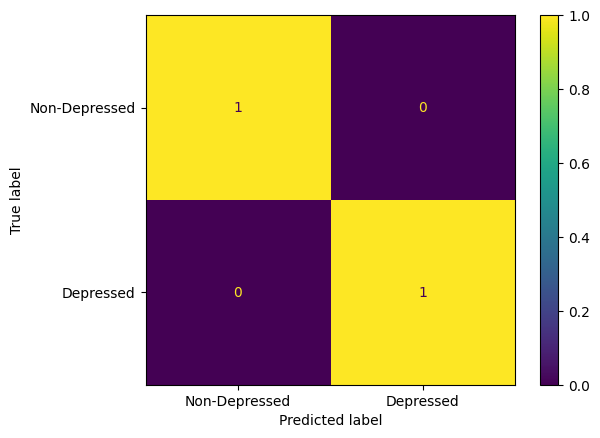

Accuracy = 1.0
Recall = 1.0
Precision = 1.0
F1-score = 1.0


In [21]:
#Predict
# y_pose_prediction = model_pose.predict(X_test_pose_np)
y_pose_prediction = model_pose.predict(x_dev_bad)
y_pose_prediction = np.argmax(y_pose_prediction, axis = 1)
# print(sum(y_pose_prediction)/len(y_pose_prediction))
print(y_pose_prediction)
# y_pose_pred = (y_pose_prediction > 0.5) # pose
# y_pred = (y_prediction > 0.5)
#Create confusion matrix and normalizes it over predicted (columns)
# result = confusion_matrix(Y_test_np, y_pose_prediction, normalize='pred')
result = confusion_matrix(y_dev_bad, y_pose_prediction, normalize='pred')
# print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["Non-Depressed", "Depressed"])
cm_display.plot()
plt.show()
tn_pose = result[0][0]
tp_pose = result[1][1]
fn_pose = result[1][0]
fp_pose = result[0][1]
accuracy = (tp_pose + tn_pose)/(tp_pose + tn_pose + fp_pose + fn_pose)
recall = tp_pose / (tp_pose + fn_pose)
precision = tp_pose / (tp_pose + fp_pose)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))

In [ ]:
#Predict
y_gaze_prediction = model_gaze.predict(X_test_gaze_np)
y_gaze_prediction = np.argmax(y_gaze_prediction, axis = 1)
# print(sum(y_gaze_prediction)/len(y_gaze_prediction))
# print(y_pose_gaze_prediction)
# y_gaze_pred = (y_gaze_prediction > 0.415) # pose + gaze
# y_pred = (y_prediction > 0.5)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(Y_test_np, y_gaze_prediction, normalize='pred')
# print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = [False, True])
cm_display.plot()
plt.show()
tn_gaze = result[0][0]
tp_gaze = result[1][1]
fn_gaze = result[1][0]
fp_gaze = result[0][1]
accuracy = (tp_gaze + tn)/(tp_gaze + tn_gaze + fp_gaze + fn_gaze)
recall = tp_gaze / (tp_gaze + fn_gaze)
precision = tp_gaze / (tp_gaze + fp_gaze)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))

2/2 [==============================] - 3s 468ms/step
0.5


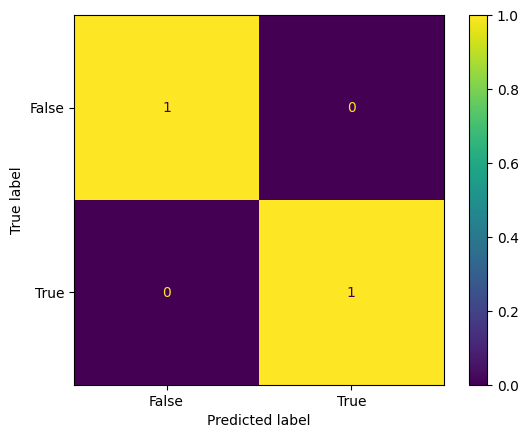

Accuracy = 1.0
Recall = 1.0
Precision = 1.0
F1-score = 1.0


In [25]:
#Predict
# y_pose_gaze_prediction = model_pose_gaze.predict([X_test_pose_np, X_test_gaze_np])
y_pose_gaze_prediction = model_pose_gaze.predict([x_dev_bad, x_dev_bad2])
y_pose_gaze_prediction = np.argmax(y_pose_gaze_prediction, axis = 1)
print(sum(y_pose_gaze_prediction)/len(y_pose_gaze_prediction))
# print(y_pose_gaze_prediction)
# y_pose_gaze_pred = (y_pose_gaze_prediction > 0.385) # pose + gaze
# y_pred = (y_prediction > 0.5)
#Create confusion matrix and normalizes it over predicted (columns)
# result = confusion_matrix(Y_test_np, y_pose_gaze_prediction, normalize='pred')
result = confusion_matrix(y_dev_bad, y_pose_gaze_prediction, normalize='pred')
# print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = [False, True])
cm_display.plot()
plt.show()
tn_pose_gaze = result[0][0]
tp_pose_gaze = result[1][1]
fn_pose_gaze = result[1][0]
fp_pose_gaze = result[0][1]
accuracy = (tp_pose_gaze + tn_pose_gaze)/(tp_pose_gaze + tn_pose_gaze + fp_pose_gaze + fn_pose_gaze)
recall = tp_pose_gaze / (tp_pose_gaze + fn_pose_gaze)
precision = tp_pose_gaze / (tp_pose_gaze + fp_pose_gaze)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))

In [ ]:
# y_pred = (y_prediction > 0.3775) # pose
# y_pred = (y_prediction > 0.67441285) # AU
# y_pred = (y_prediction > 0.29832837) # gaze

In [ ]:
print(model_pose.evaluate(x=X_test_pose_np, y=Y_test_np))
print(model_gaze.evaluate(x=X_test_gaze_np, y=Y_test_np))
print(model_pose_gaze.evaluate(x=[X_test_pose_np, X_test_gaze_np], y=Y_test_np))

In [ ]:
model_pose.summary()

In [56]:
model_pose.save("saved_models/discriminates_on_pose_dev")

INFO:tensorflow:Assets written to: saved_models/discriminates_on_pose_dev\assets


INFO:tensorflow:Assets written to: saved_models/discriminates_on_pose_dev\assets
